# Predicting the Football (Soccer) World Cup Winner with Machine Learning

**Aim:** to predict the outcome of the FIFA World Cup 2018

**Method:**

1. Use data from Kaggle to model the outcome of certain pairings between teams, given their rank, points, and the weighted point difference with the opponent.
2. Use this model to predict the outcome of the group rounds and then the single-elimination phase

Summary According to the analysis below, the team that will win the World Cup is the underdog according to the bookies: Germany . But this is not the only interesting thing you can observe. If not interested in the data munging part head to the last section (Visualization) and see the single-elimination phase. To make the story more interesting for the sport lovers, I report fair odds (i.e. fair market, without bookmaker margin) instead of the raw probability output.


# Data I/O
Three datasets were used:

1. FIFA rankings from 1993 to 2018 - used to get the FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a decent predictor of team performance

2. International Soccer matches from 1872 to 2018 (courtesy of Mart Jürisoo) - to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match

3. FIFA World Cup 2018 data set (courtesy of Nuggs) -  to get the upcoming matches


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from matplotlib import pyplot as plt


# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/fifa_ranking-2022-10-06.csv")
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'total_points', 'rank_date']]
old_rankings = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/fifa_ranking.csv")
old_rankings = old_rankings.loc[:,['rank', 'country_full', 'country_abrv', 'total_points', 'rank_date']]

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['total_points']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) # change to pandas datetime format

# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/till-2022-results.csv")
# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'], format='%Y-%m-%d')
matches['year'] = matches['date'].dt.year

# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/Worldcup2022.csv")

# extract relavent columns
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match against', 'Second match against', 'Third match against']]

# Drop NAs
world_cup = world_cup.dropna(how='all')

# Fix some country names
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic",
                               "Netherland": "Netherlands"})
# set index to team 
world_cup = world_cup.set_index('Team')

# Get elo rating data
elo_rating = pd.read_csv("https://raw.githubusercontent.com/iamtlcs/STAT3011-Group5-Project2/main/elo_rating-1992-2022.csv")
elo_rating = elo_rating.loc[:,['country', 'elo', 'year']]
elo_rating = elo_rating.replace({"United States": "USA", "South Korea" : "Korea Republic"})

/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '31/12/1992' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '22/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19/11/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/usr/local/lib/python3.9/dist-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '23/12/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime

In [15]:
rankings.head()

,rank,country_full,country_abrv,total_points,rank_date,weighted_points
0,74.0,Madagascar,MAD,18.0,1992-12-31,18.0
1,52.0,Qatar,QAT,27.0,1992-12-31,27.0
2,51.0,Senegal,SEN,27.0,1992-12-31,27.0
3,50.0,El Salvador,SLV,28.0,1992-12-31,28.0
4,49.0,Korea Republic,KOR,28.0,1992-12-31,28.0


In [16]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876


In [17]:
world_cup.head()

,Group,First match against,Second match against,Third match against
Team,,,,
Qatar,A,Ecuador,Senegal,Netherlands
Ecuador,A,Qatar,Netherlands,Senegal
Senegal,A,Netherlands,Qatar,Ecuador
Netherlands,A,Senegal,Ecuador,Qatar
England,B,Iran,USA,Wales


In [18]:
elo_rating.head()

,country,elo,year
0,Germany,2087,1992
1,France,2009,1992
2,England,1987,1992
3,Argentina,1983,1992
4,Italy,1971,1992


# 2. Feature extraction

We join the matches with the ranks of the different teams.

Then extract some features:

- point and rank differences
- if the game was for some stakes, because my naive view was that typically friendly matches are harder to predict

In [19]:
# we want to have the ranks for every day 
# We use resample to sample by Day and get the first date
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
rankings['year'] = rankings['rank_date'].dt.year   
rankings.head()

,rank_date,rank,country_full,country_abrv,total_points,weighted_points,year
0,2003-01-15,204.0,Afghanistan,AFG,7.0,7.0,2003
1,2003-01-16,204.0,Afghanistan,AFG,7.0,7.0,2003
2,2003-01-17,204.0,Afghanistan,AFG,7.0,7.0,2003
3,2003-01-18,204.0,Afghanistan,AFG,7.0,7.0,2003
4,2003-01-19,204.0,Afghanistan,AFG,7.0,7.0,2003


In [20]:
elo_rating.head()

,country,elo,year
0,Germany,2087,1992
1,France,2009,1992
2,England,1987,1992
3,Argentina,1983,1992
4,Italy,1971,1992


In [21]:
rankings = rankings.merge(elo_rating, 
                        left_on=['year', 'country_full'], 
                        right_on=['year', 'country'])
rankings.head()

,rank_date,rank,country_full,country_abrv,total_points,weighted_points,year,country,elo
0,2003-01-15,204.0,Afghanistan,AFG,7.0,7.0,2003,Afghanistan,862
1,2003-01-16,204.0,Afghanistan,AFG,7.0,7.0,2003,Afghanistan,862
2,2003-01-17,204.0,Afghanistan,AFG,7.0,7.0,2003,Afghanistan,862
3,2003-01-18,204.0,Afghanistan,AFG,7.0,7.0,2003,Afghanistan,862
4,2003-01-19,204.0,Afghanistan,AFG,7.0,7.0,2003,Afghanistan,862


### Adding Fifa Rankings to Match Data

In [22]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876


In [23]:
# join the ranks
# First we do it for the Home team
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country_x,neutral,year_x,rank_date,rank,country_full,country_abrv,total_points,weighted_points,year_y,country_y,elo
0,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,1993,1993-01-01,39.0,Ghana,GHA,34.0,34.0,1993,Ghana,1628
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,1993,1993-01-02,55.0,Gabon,GAB,27.0,27.0,1993,Gabon,1481
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False,1993,1993-01-02,71.0,Kuwait,KUW,21.0,21.0,1993,Kuwait,1477
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,1993,1993-01-03,97.0,Burkina Faso,BFA,11.0,11.0,1993,Burkina Faso,1425
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,1993,1993-01-03,55.0,Gabon,GAB,27.0,27.0,1993,Gabon,1481


In [24]:
# Next we do it for the Away teams
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country_x,neutral,year_x,...,elo_home,rank_date_away,rank_away,country_full_away,country_abrv_away,total_points_away,weighted_points_away,year,country,elo_away
0,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,1993,...,1628,1993-01-01,69.0,Mali,MLI,22.0,22.0,1993,Mali,1468
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,1993,...,1481,1993-01-02,97.0,Burkina Faso,BFA,11.0,11.0,1993,Burkina Faso,1425
2,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,1993,...,1425,1993-01-03,69.0,Mali,MLI,22.0,22.0,1993,Mali,1468
3,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,1993,...,1481,1993-01-03,39.0,Ghana,GHA,34.0,34.0,1993,Ghana,1628
4,1993-01-08,Uganda,Tanzania,3,1,Friendly,Kampala,Uganda,False,1993,...,1507,1993-01-08,80.0,Tanzania,TAN,15.0,15.0,1993,Tanzania,1315


In [25]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['elo_difference'] = matches['elo_home'] - matches['elo_away']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country_x,neutral,year_x,...,year,country,elo_away,rank_difference,average_rank,point_difference,score_difference,elo_difference,is_won,is_stake
0,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,1993,...,1993,Mali,1468,-30.0,54.0,12.0,0,160,False,False
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,1993,...,1993,Burkina Faso,1425,-42.0,76.0,16.0,0,56,False,False
2,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,1993,...,1993,Mali,1468,28.0,83.0,-11.0,1,-43,True,False
3,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,1993,...,1993,Ghana,1628,16.0,47.0,-7.0,-1,-147,False,False
4,1993-01-08,Uganda,Tanzania,3,1,Friendly,Kampala,Uganda,False,1993,...,1993,Tanzania,1315,12.0,86.0,-3.0,2,192,True,False


# 3. Modeling
I used a simple Logistic regression, which yielded already rather good performance

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.72      0.67      0.69      2210
        True       0.66      0.71      0.68      1972

    accuracy                           0.69      4182
   macro avg       0.69      0.69      0.69      4182
weighted avg       0.69      0.69      0.69      4182



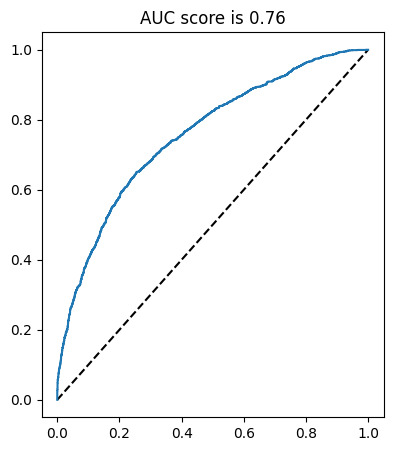

In [26]:
from sklearn import *
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report

# We look at only 4 features
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'elo_difference', 'is_stake']], matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Use a logistic Regression model
logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# Plot our model results 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

I consider this pretty good performance, minding that soccer matches have typically only few goals scored and therefore making their outcome even more unpredictable. 

Nevertheless, let's look at the bad predictions and see where we are making mistakes more often.

Stakes distribution in the wrong predictions
True     0.612135
False    0.387865
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.646195
False    0.353805
Name: is_stake, dtype: float64


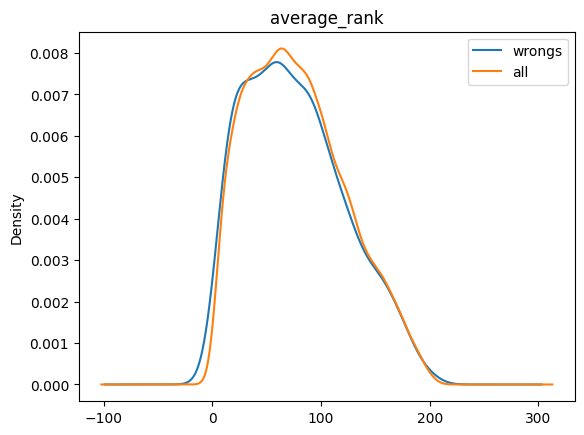

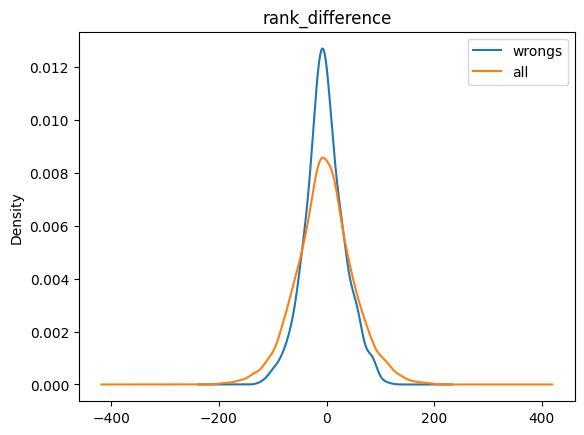

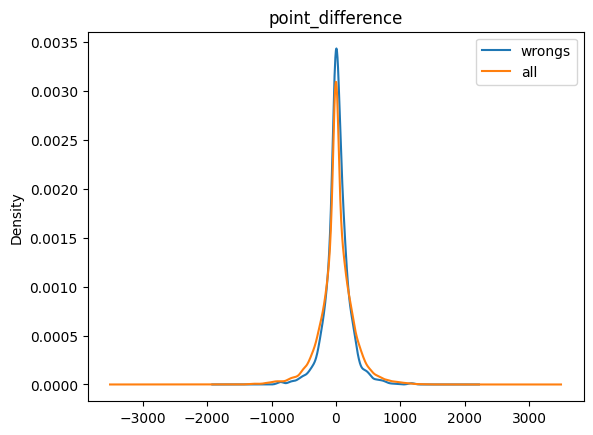

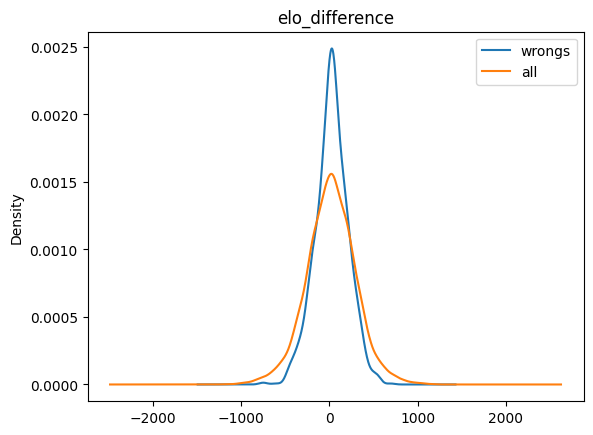

In [27]:
features = ['average_rank', 'rank_difference', 'point_difference', 'elo_difference']

# Get the wrongly predicted matches
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read

- we predict worse for closer ranks
- lower ranks in general
- and somewhat for matches with no stakes (Friendly here) - fortunately, this implies that for the world cup our predicitons may be somewhat even better

# 4. World Cup simulation

In [28]:
# let's define a small margin that we add, so that we predict draws when probabilies lie between 0.475 and 0.525
margin = 0.07

# let's define the rankings at the time of the World Cup (so we sort on most recent rankings)
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
world_cup_rankings.head()

,rank_date,rank,country_abrv,total_points,weighted_points,year,country,elo
country_full,,,,,,,,
Argentina,2022-10-02,4.0,ARG,1766.99,1766.99,2022,Argentina,2101
Australia,2022-10-02,37.0,AUS,1486.86,1486.86,2022,Australia,1733
Belgium,2022-10-02,1.0,BEL,1828.45,1828.45,2022,Belgium,2075
Brazil,2022-10-02,2.0,BRA,1823.42,1823.42,2022,Brazil,2149
Cameroon,2022-10-02,38.0,CMR,1480.82,1480.82,2022,Cameroon,1610


In [29]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        opp_elo = world_cup_rankings.loc[away, 'elo']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        
        # get the prediction proability of the home team winning
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group C:___
Poland vs. Saudi Arabia: Poland wins with 0.59
Poland vs. Argentina: Argentina wins with 0.63
Poland vs. Mexico: Draw
Saudi Arabia vs. Argentina: Argentina wins with 0.75
Saudi Arabia vs. Mexico: Mexico wins with 0.66
Argentina vs. Mexico: Argentina wins with 0.64
___Starting group F:___
Croatia vs. Canada: Draw
Croatia vs. Belgium: Belgium wins with 0.58
Croatia vs. Morocco: Draw
Canada vs. Belgium: Belgium wins with 0.66
Canada vs. Morocco: Draw
Belgium vs. Morocco: Belgium wins with 0.69
___Starting group D:___
France vs. Australia: France wins with 0.73
France vs. Denmark: France wins with 0.60
France vs. Tunisia: France wins with 0.79
Australia vs. Denmark: Denmark wins with 0.63
Australia vs. Tunisia: Draw
Denmark vs. Tunisia: Denmark wins with 0.66
___Starting group G:___
Serbia vs. Cameroon: Serbia wins with 0.64
Serbia vs. Switzerland: Draw
Serbia vs. Brazil: Brazil wins with 0.62
Cameroon vs. Switzerland: Switzerland wins with 0.66
Cameroon vs. Brazil:

# Single-elimination rounds

In [30]:
world_cup

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Qatar,A,Ecuador,Senegal,Netherlands,1,1.146184
Ecuador,A,Qatar,Netherlands,Senegal,6,1.615389
Senegal,A,Netherlands,Qatar,Ecuador,1,1.398060
Netherlands,A,Senegal,Ecuador,Qatar,9,1.840368
England,B,Iran,USA,Wales,9,1.827198
Iran,B,England,Wales,USA,2,1.353289
Wales,B,USA,Iran,England,2,1.360894
USA,B,Wales,England,Iran,2,1.458619
Poland,C,Mexico,Saudi Arabia,Argentina,4,1.403561


In [31]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Netherlands,A,Senegal,Ecuador,Qatar,9,1.840368
Ecuador,A,Qatar,Netherlands,Senegal,6,1.615389
USA,B,Wales,England,Iran,2,1.458619
England,B,Iran,USA,Wales,9,1.827198
Argentina,C,Saudi Arabia,Mexico,Poland,9,2.028350
Mexico,C,Poland,Argentina,Saudi Arabia,4,1.576809
Denmark,D,Tunisia,France,Australia,6,1.686479
France,D,Australia,Denmark,Tunisia,9,2.120712
Spain,E,Costa Rica,Germany,Japan,7,1.834051


In [32]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        opp_elo = world_cup_rankings.loc[away, 'elo']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo

        # Get the winner
        home_win_prob = model.predict_proba(row)[:,1][0]
        
        # Display resultes
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Netherlands vs. USA: Netherlands wins with probability 0.53
Argentina vs. Denmark: Argentina wins with probability 0.59
Spain vs. Croatia: Spain wins with probability 0.59
Brazil vs. Uruguay: Brazil wins with probability 0.69
Ecuador vs. England: England wins with probability 0.66
Mexico vs. France: France wins with probability 0.56
Germany vs. Belgium: Belgium wins with probability 0.56
Switzerland vs. Portugal: Portugal wins with probability 0.52


___Starting of the quarterfinal___
Netherlands vs. Argentina: Argentina wins with probability 0.55
Spain vs. Brazil: Brazil wins with probability 0.54
England vs. France: France wins with probability 0.52
Belgium vs. Portugal: Belgium wins with probability 0.57


___Starting of the semifinal___
Argentina vs. Brazil: Brazil wins with probability 0.52
France vs. Belgium: France wins with probability 0.50


___Starting of the final___
Brazil vs. France: Brazil wins with probability 0.52




# Let's see a visualization

<ipython-input-33-c7a849c26e95>:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='twopi')


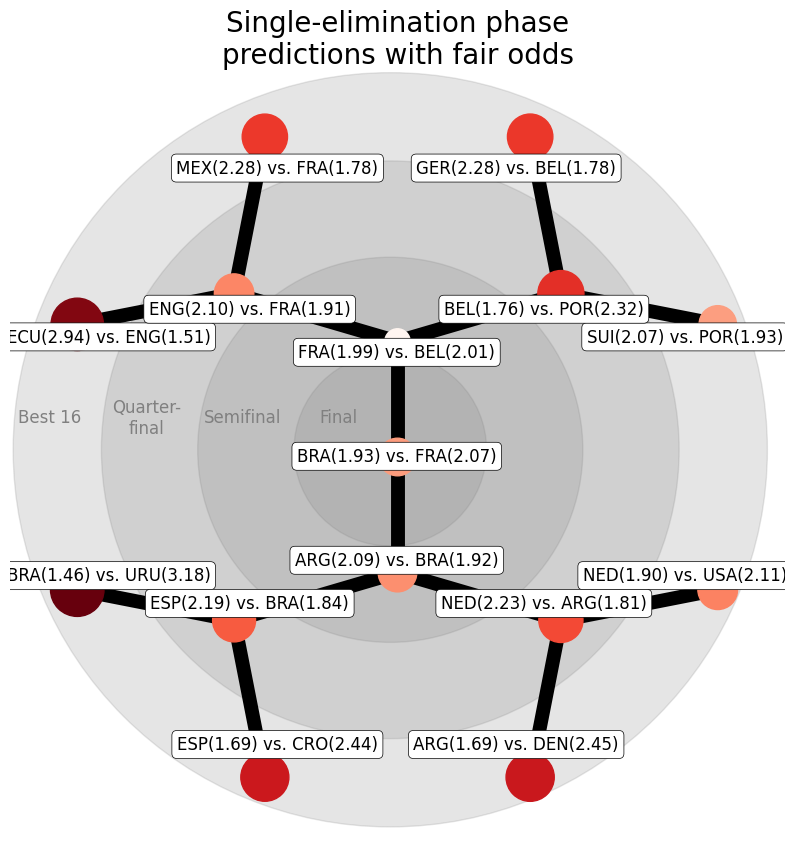

In [33]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)

# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()


# Improvement
## Random Forest Simulation

1. Import necessary libraries

# Actual Results to compare

![](https://library.sportingnews.com/styles/crop_style_16_9_desktop_webp/s3/2022-12/Argentina%202.jpg.webp?itok=_Ab-El6g)